# allganize-RAG-Evaluation data + colpali search
## Methodology
1. pdf -> Image using `PDF2ImageReader`
2. split each image into own chunk
3. embed using colsmol based model
4. store embedding using qdrant with `QdrantLateInteractionVectorStore`

## Env
* model: `vidore/colSmol-500M`
    * https://huggingface.co/vidore/colSmol-500M
    * `SmolVLM-500M` model trained for visual retrieval
* data: real-life pdf files from `allganize-RAG-Evaluation-Dataset-KO`
    * https://huggingface.co/datasets/allganize/RAG-Evaluation-Dataset-KO
    * use 10 'finance' domain files

In [1]:
import json
from pathlib import Path
import time
from typing import Any, Dict, List, Optional

import jsonlines
import pandas as pd
from tqdm import tqdm

from config import settings

In [2]:
import sys
import os

parent_dir = os.path.dirname(os.getcwd())
core_src_dir = os.path.join(parent_dir, "src/psiking")
sys.path.append(core_src_dir)

In [3]:
## Import Core Schemas
from core.base.schema import Document, TextNode

# 1. Read Data
* 10 pdf files, convert to image with pdf2image

In [4]:
from core.reader import PDF2ImageReader

# testing on macOS, provide poppler path manually
poppler_path = "/opt/homebrew/Cellar/poppler/25.01.0/bin"
reader = PDF2ImageReader(poppler_path=poppler_path)

In [5]:
# PDF File directory
pdf_dir = os.path.join(settings.data_dir, "allganize-RAG-Evaluation-Dataset-KO/finance")
pdf_fnames =[x for x in os.listdir(pdf_dir) if x.endswith(".pdf")]
print("num files:", len(pdf_fnames))
pdf_fnames[:10]

num files: 10


['★2019 제1회 증시콘서트 자료집_최종★.pdf',
 '240409(보도자료) 금융위 핀테크 투자 생태계 활성화 나선다.pdf',
 '2024년 3월_3. 향후 통화신용정책 방향.pdf',
 '133178946057443204_WP22-05.pdf',
 '240130(보도자료) 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '130292099630937500_KIFVIP2013-10.pdf',
 '2024년 3월_2. 통화신용정책 운영.pdf',
 '[별첨] 지방은행의 시중은행 전환시 인가방식 및 절차.pdf',
 '240320(보도자료) 금융권의 상생금융 추진현황.pdf',
 '한-호주 퇴직연금 포럼_책자(최종).pdf']

In [6]:
# Convert pages to image

documents = []
for doc_i, fname in tqdm(enumerate(pdf_fnames)):
    file_path = os.path.join(pdf_dir, fname)
    document = reader.run(
        file_path,
        extra_info = {
            "source_id": f"allganize-RAG-Evaluation-Dataset-KO/finance/{doc_i}", # arbitrary id
            "domain": "finance",
            "source_file": fname
        }
    )
    document.nodes = document.nodes[:3] ## test with only first 10 pages
    documents.append(document)
    
for node in document.nodes[:2]:
    print(type(node))

0it [00:00, ?it/s]

10it [00:46,  4.68s/it]

<class 'core.base.schema.ImageNode'>
<class 'core.base.schema.ImageNode'>


In [7]:
document.metadata

{'source_id': 'allganize-RAG-Evaluation-Dataset-KO/finance/9',
 'domain': 'finance',
 'source_file': '한-호주 퇴직연금 포럼_책자(최종).pdf'}

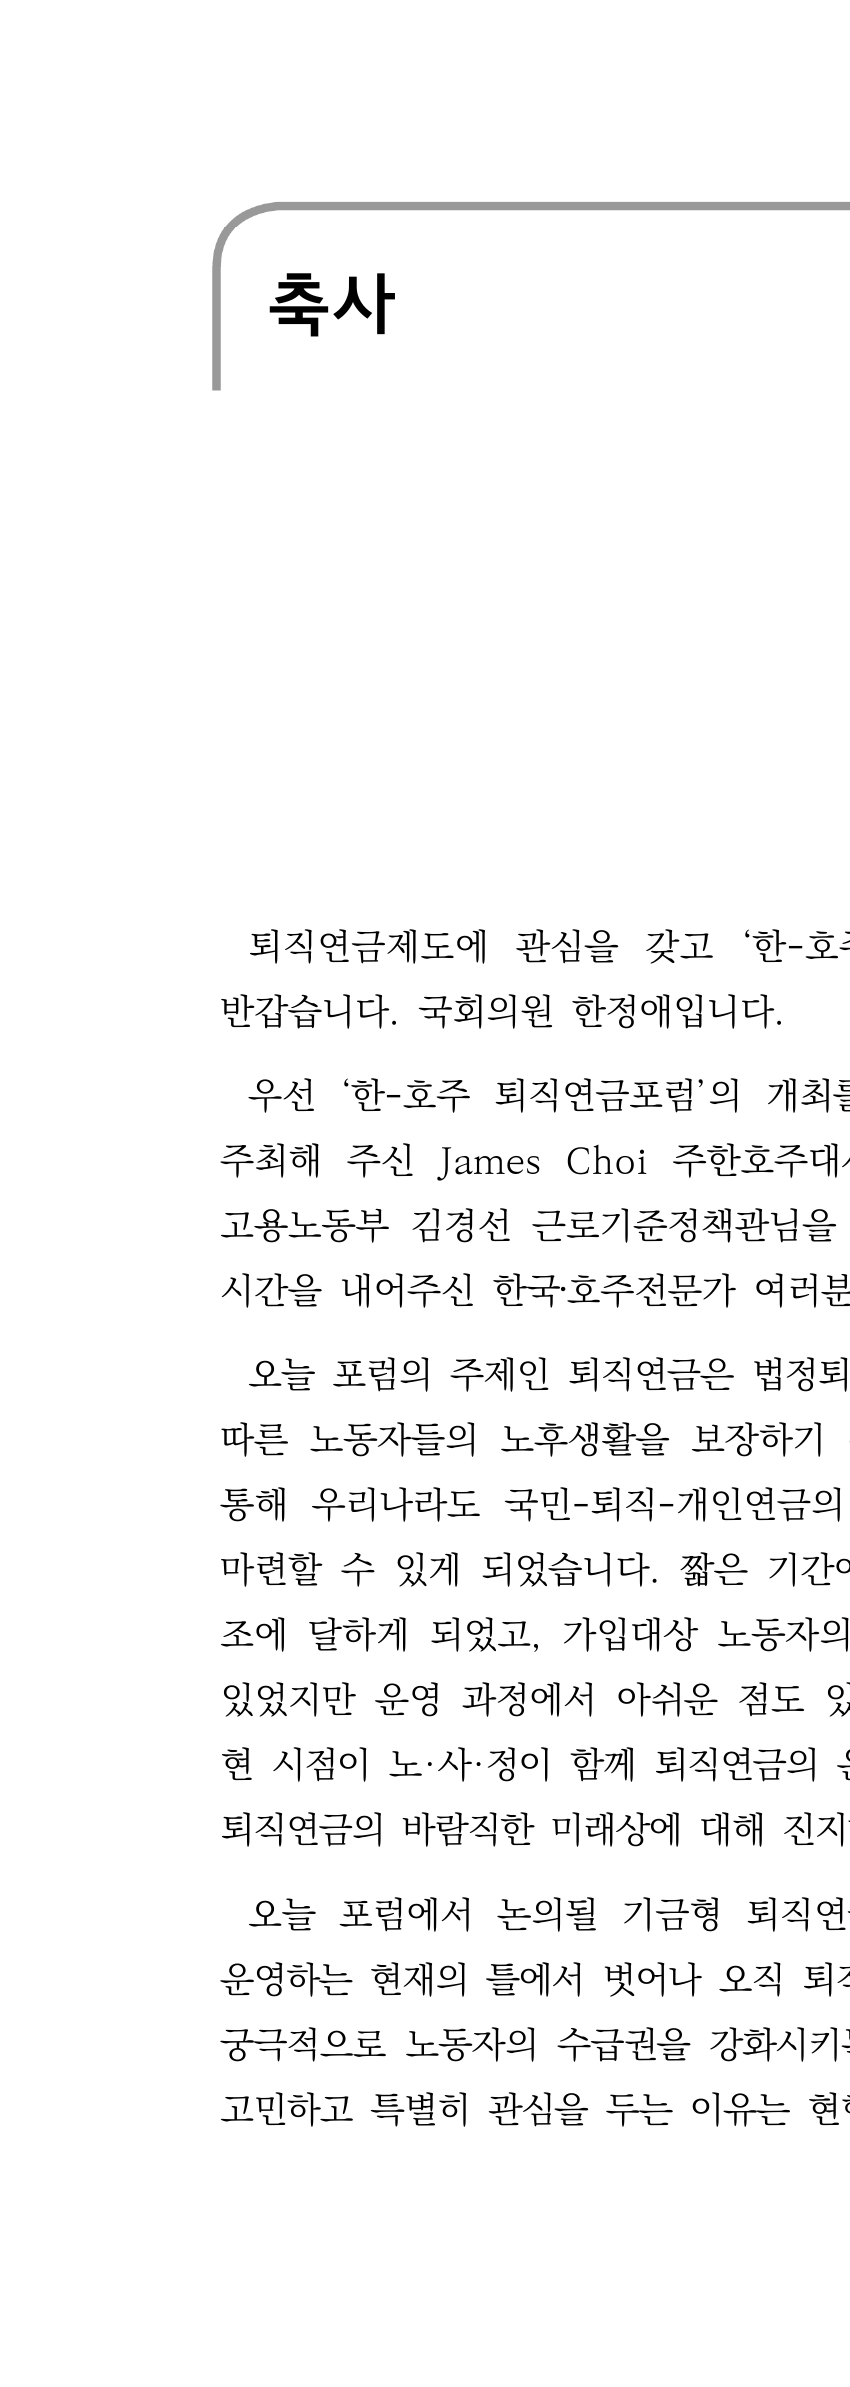

In [8]:
image = document.nodes[0].image

# Crop to half
width, height = image.size
left_half = image.crop((0, 0, width, height//2))
left_half

# 2. Run Splitter

In [9]:
# Split Documents page-level

chunks = []
for document in documents:
    source_id = document.id_
    for node in document.nodes:
        chunk = Document(
            nodes=[node],
            metadata={
                "source_id": source_id,
                "domain": document.metadata["domain"],
                "source_file": document.metadata["source_file"],
            }
        )
        chunks.append(chunk)
print(len(chunks))

30


# 3. Embed Using ColPali

In [10]:
import torch
from transformers import AutoTokenizer
from colpali_engine.models import ColIdefics3, ColIdefics3Processor

# Load Colpali engine
model_dir = os.path.join(
    settings.model_weight_dir, "multimodal_retriever/colSmol-500M"
)

model = ColIdefics3.from_pretrained(
    model_dir,
    torch_dtype=torch.bfloat16,
).eval()
model.to("mps")
tokenizer = AutoTokenizer.from_pretrained(model_dir)
processor = ColIdefics3Processor.from_pretrained(model_dir)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [11]:
from core.embedder.colpali.local_colpali_engine import LocalColpaliEngineEmbedder
embedder = LocalColpaliEngineEmbedder(
    model=model,
    processor=processor,
    tokenizer=tokenizer
)

In [12]:
model.dtype

torch.bfloat16

In [13]:
import itertools

embeddings = []
embeddings = embedder.run(
    nodes=itertools.chain(*[x.nodes for x in documents]),
    batch_size=3
)

In [14]:
# (page_num, seq_len, embedding_dim)
print(len(embeddings))
print(len(embeddings[0]))
print(len(embeddings[0][0]))

30
871
128


# 4. Insert into VectorStore
* intialize qdrant in-memory

In [16]:
from qdrant_client import QdrantClient
from core.storage.vectorstore.qdrant import QdrantLateInteractionVectorStore

# initialize client
client = QdrantClient(":memory:")
collection_name = "allganize-finance"
vector_store = QdrantLateInteractionVectorStore(
    collection_name=collection_name,
    client=client
)

In [17]:
from qdrant_client.http import models

embedding_dim = 128

vector_store.create_collection(
    on_disk_payload=True,
    vectors_config=models.VectorParams(
        size=embedding_dim,
        distance=models.Distance.COSINE,
        on_disk=True,
        # Set to use MaxSim operation
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        # Quantize to binary vector
        quantization_config=models.BinaryQuantization(
            binary=models.BinaryQuantizationConfig(
                always_ram=True
            ),
        ),
    ),
)

In [18]:
vector_store.add(
    documents=chunks,
    embeddings=embeddings
)

In [19]:
chunks[0].id_

'6a1ebb74-9907-4e2a-ba13-86369fba274b'

In [20]:
points = vector_store._client.retrieve(
    collection_name=vector_store.collection_name,
    ids=[chunks[0].id_],
    with_vectors=True
)

In [21]:
print(points[0].id)
print(points[0].payload)
print(len(points[0].vector))
print(len(points[0].vector[0]))

6a1ebb74-9907-4e2a-ba13-86369fba274b
{'source_id': '158690bd-0022-4bff-9c43-4a429f4da3ef', 'domain': 'finance', 'source_file': '★2019 제1회 증시콘서트 자료집_최종★.pdf'}
871
128
